## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'stft-female' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
female_stft_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\stft\\female'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


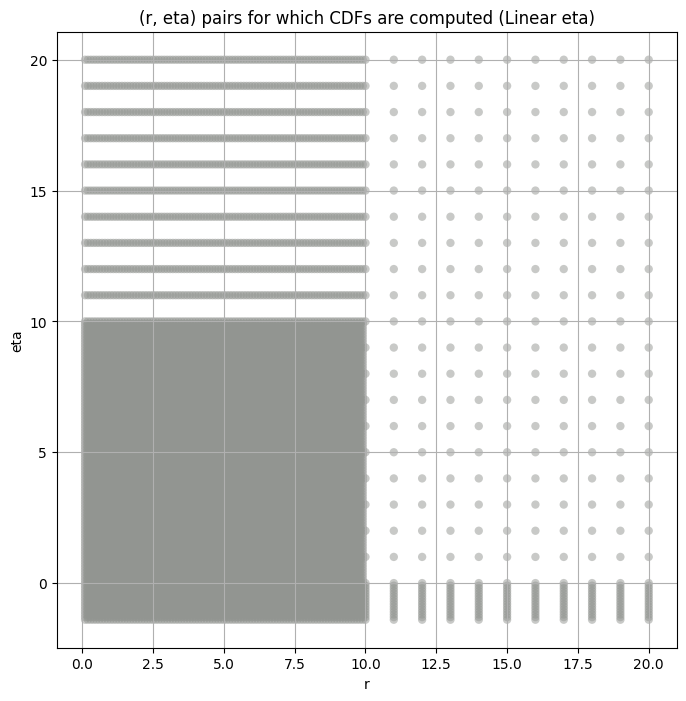

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,75.385260,60.889893,97.033820,81.302400,27.247470,234.38525,7281120.0
3,29.017336,24.287535,36.556973,61.603676,21.173878,214.87718,7281120.0
4,17.254368,13.904614,23.667818,109.402435,27.565727,413.15738,7281120.0
5,14.269713,10.821849,23.366629,269.051480,40.843310,922.23236,29124480.0
6,4.402337,3.275878,7.698638,353.294860,42.218037,1140.06900,14562240.0
7,1.025797,0.778365,1.671800,261.067350,39.629406,905.90160,14562240.0
8,0.383323,0.286673,0.647704,305.185270,44.338146,1020.47360,14562240.0
9,0.250326,0.179886,0.378133,216.880750,69.899605,652.36780,14789775.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,75.385260,75.385262,64.707344,60.338478,57.248947,54.810772,51.026600,48.105843,45.711849,43.679985,41.909103,37.644928
3,29.017336,29.017336,25.789114,24.390676,23.343815,22.492275,21.129114,20.040285,19.126043,18.335339,17.637970,15.927531
4,17.254368,17.254368,14.865458,13.919744,13.218337,12.646924,11.737138,11.020642,10.428157,9.921701,9.480530,8.418941
5,14.269713,14.269713,11.736312,10.843790,10.169940,9.615511,8.725152,8.019291,7.434284,6.935843,6.502779,5.473347
6,4.402337,4.402337,3.545656,3.265570,3.056427,2.886097,2.614708,2.400972,2.224590,2.074504,1.944310,1.636526
7,1.025797,1.025797,0.844421,0.781017,0.733216,0.694075,0.631343,0.581578,0.540278,0.505021,0.474347,0.401431
8,0.383323,0.383323,0.313237,0.288067,0.268944,0.253244,0.228138,0.208391,0.192169,0.178462,0.166660,0.139144
9,0.250326,0.250326,0.197793,0.175651,0.159612,0.146918,0.127414,0.112737,0.101108,0.091609,0.083699,0.066217


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0036078027333397156 75.38526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.0045549665688463525 64.707344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.0026111611725511755 60.338478


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0038053122186610944 57.248947


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.004724752439833002 54.810772


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.006143579349958239 51.0266


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.005124412360571817 48.105843


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.006235477921045906 45.71185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.0075600728878380125 43.679985


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.00889620830063692 41.909103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.008672424282946647 37.644928
Number of samples: 100000, Without approximation : 7281120.0


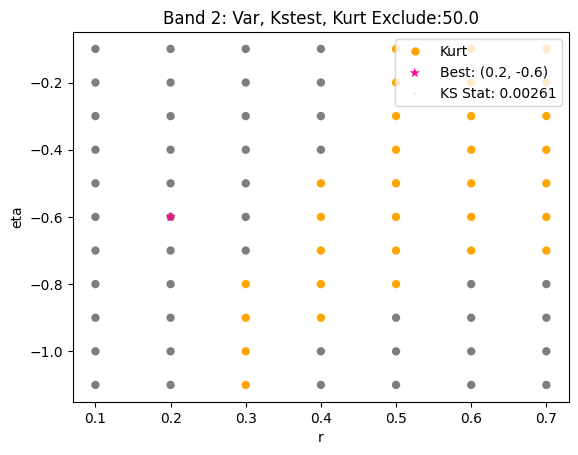

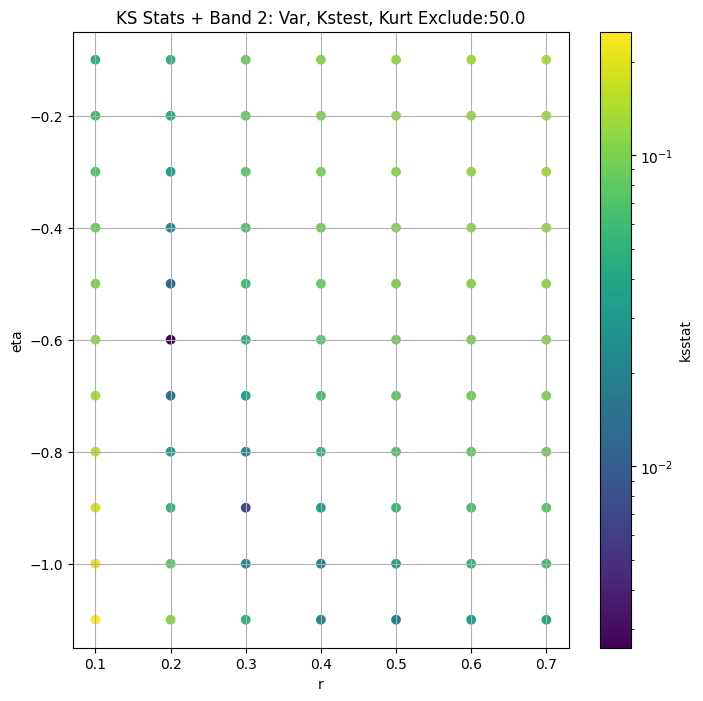

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.006281424546190129 29.017336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.00589134217321563 25.789114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0025929611722960155 24.390676


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0026306544561847875 23.343815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.003582778735817249 22.492275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.0054492713532472425 21.129114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.004504194710595089 20.040285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.005616172693511914 19.126043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.006827946376898111 18.335339


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.006965416728911267 17.63797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.008378729764565274 15.927531
Number of samples: 100000, Without approximation : 7281120.0


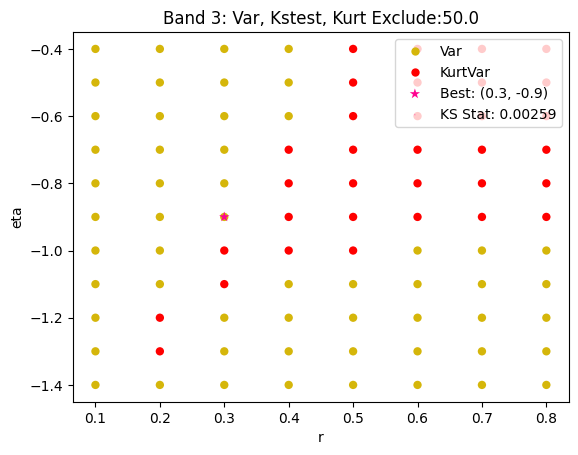

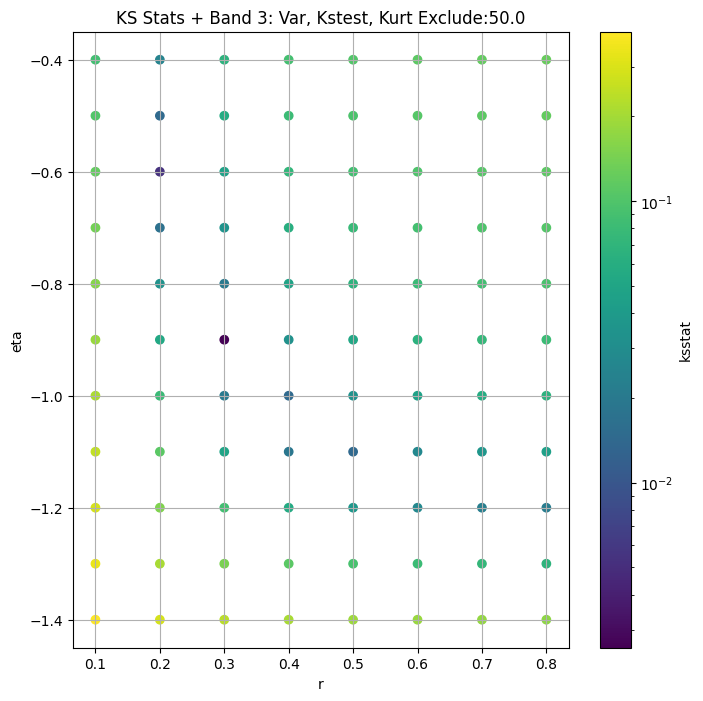

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.008084110644544618 17.254368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.004067070012624269 14.865458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.0077233640661777125 13.919744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.005298673265469067 13.218337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.003464269738249204 12.646924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.004632667584814842 11.737138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.006848866493555858 11.020642


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.008934408424935536 10.428157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.009622975670217138 9.921701


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.010320473296628274 9.48053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.00854279464480727 8.418941
Number of samples: 100000, Without approximation : 7281120.0


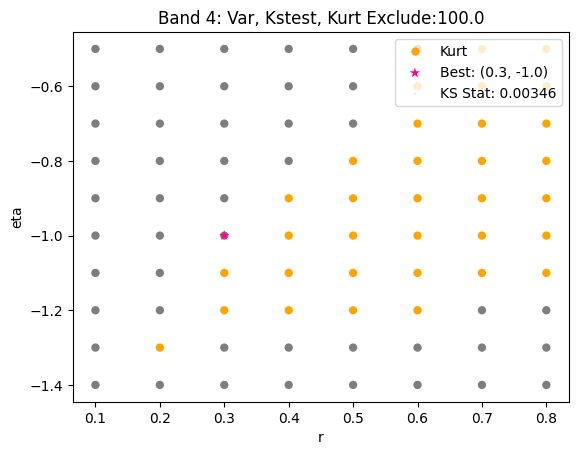

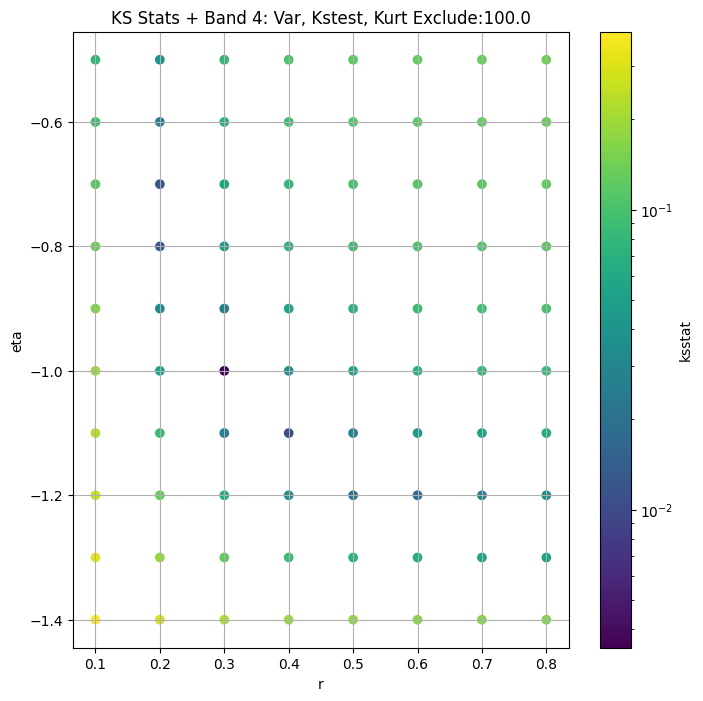

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.010458616924172937 14.269713


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.010111207620331686 11.736312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.006103292778921632 10.84379


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.005286571643261621 10.16994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.006339687336119948 9.615511


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.00651434287550188 8.725152


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.007635190245612378 8.019291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008017169226443608 7.4342837


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.008997828992301612 6.9358425


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.009989784485260424 6.5027795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009805289012284408 5.4733467
Number of samples: 100000, Without approximation : 29124480.0


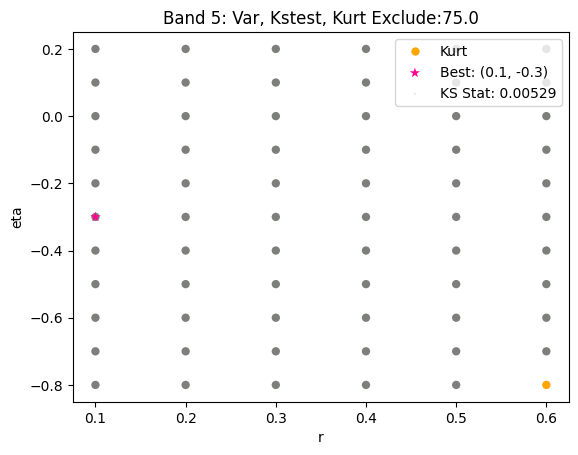

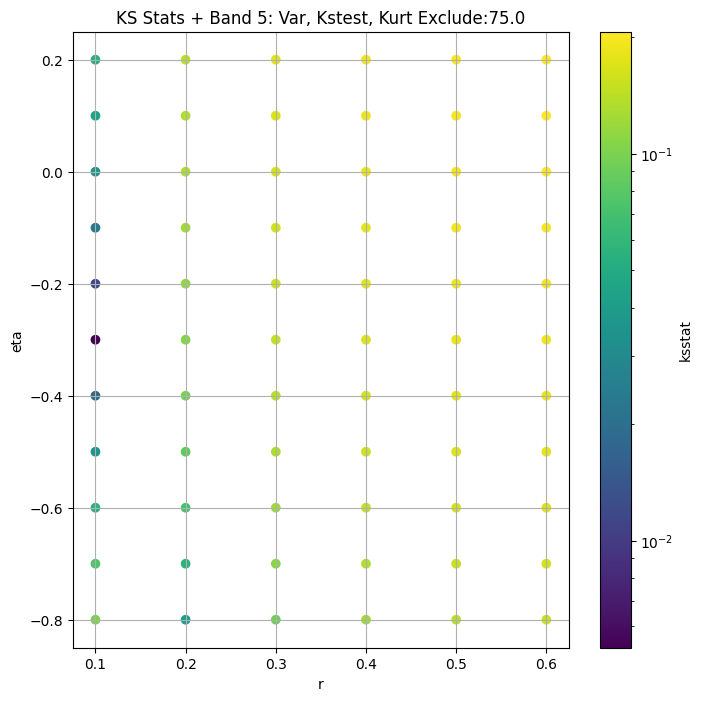

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.012531936704832547 4.402337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.008614626278686477 3.5456557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.011025424263305161 3.26557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.008971751458340171 3.0564265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.006117710210829741 2.8860974


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008402360461941483 2.6147082


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.006995432119054687 2.4009717


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.007499817911336618 2.22459


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.00840961906412703 2.0745037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.008851181973629252 1.9443102


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.00981406742914065 1.6365263
Number of samples: 100000, Without approximation : 14562240.0


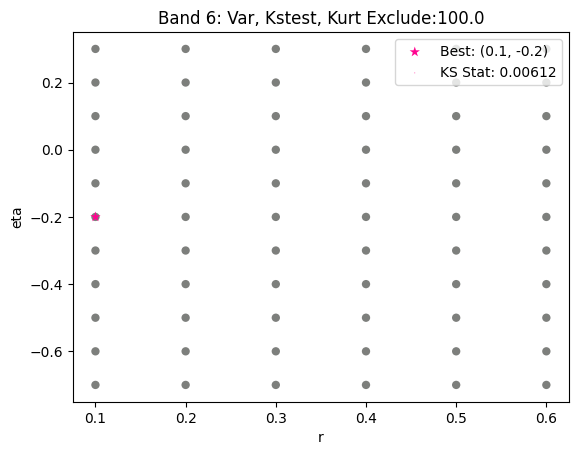

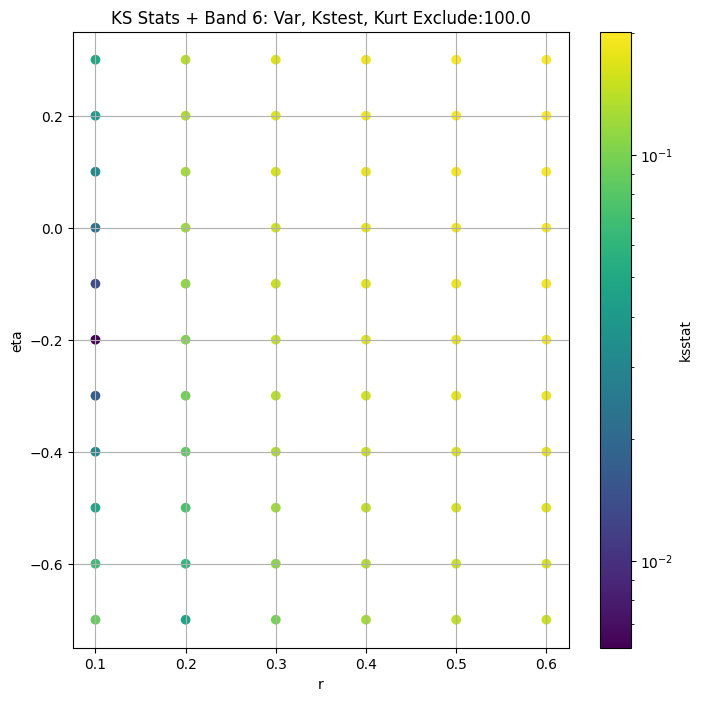

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.01637712378440226 1.025797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.013605821237877458 0.84442145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.009569630986641098 0.78101736


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.009973333764552172 0.733216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.009887749809930346 0.6940746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0065644351304262605 0.63134307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.006481771696479788 0.58157814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.007045012717936639 0.5402778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.007582687654498292 0.5050213


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.008120866897275252 0.47434714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.010167326191512956 0.4014311
Number of samples: 100000, Without approximation : 14562240.0


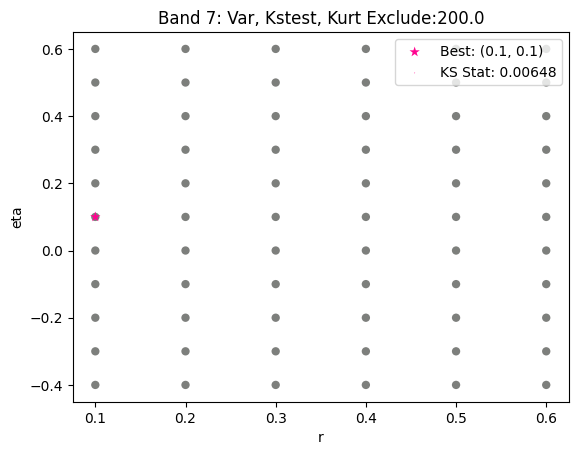

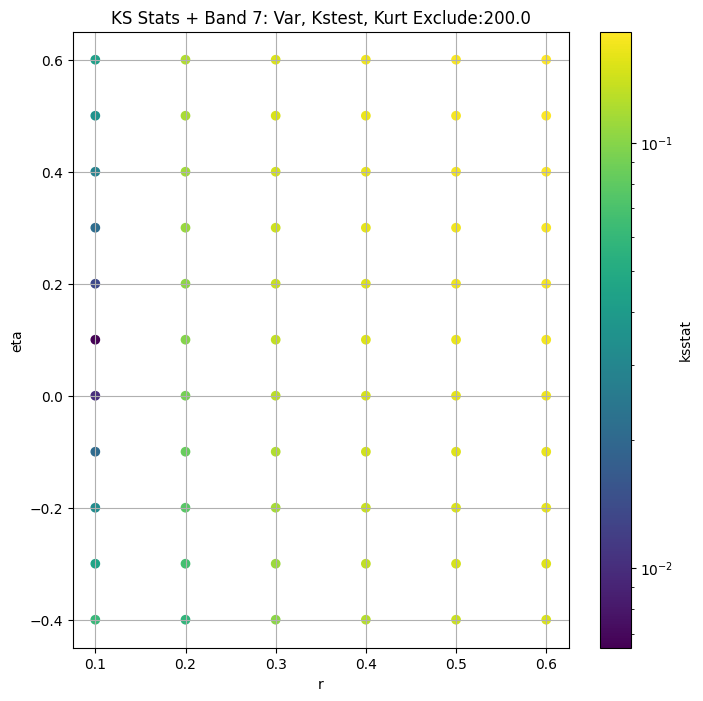

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.01670495348163442 0.38332254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.014153813710535756 0.31323668


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.014936351810611148 0.28806686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.011332024271266117 0.26894373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.013189855908883608 0.25324374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.00896005103449976 0.22813778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008735284535969168 0.20839097


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.008199143224770944 0.19216931


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.00646098775724761 0.17846231


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007040340984642315 0.1666603


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.00887062856531064 0.13914369
Number of samples: 100000, Without approximation : 14562240.0


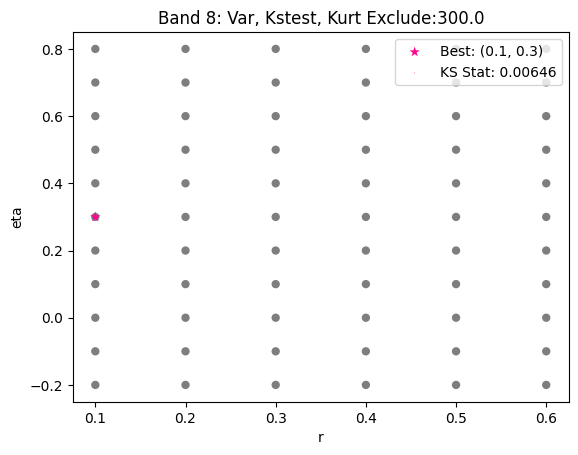

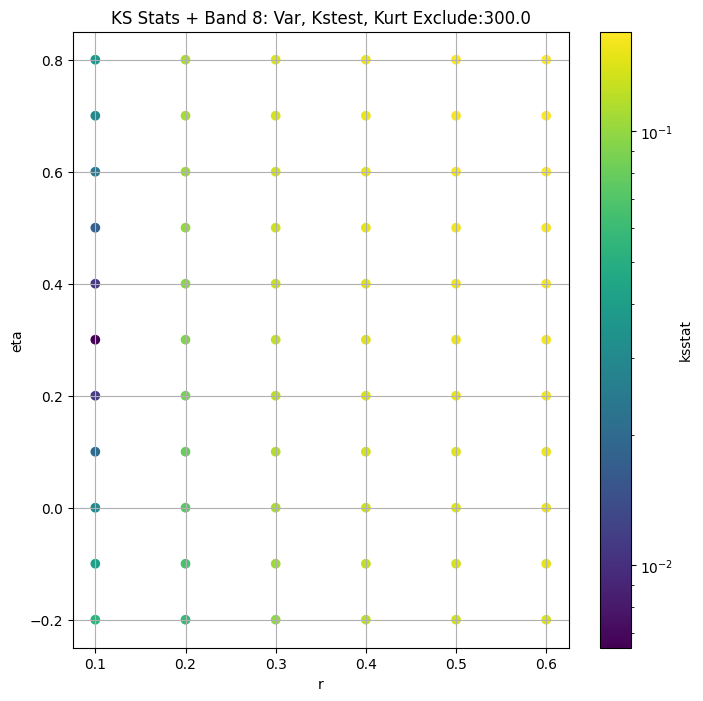

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.018218652175359562 0.25032574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.013030267956451569 0.1977928


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.014995346592928463 0.17565069


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.010739475073596183 0.15961231


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.011124927527453143 0.14691833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.007759999999737532 0.1274138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.007760818933235325 0.112737104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.0077603060285187375 0.1011075


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.007761428161285999 0.09160894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.007761032919917588 0.083699204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.007760003514552527 0.066217214
Number of samples: 100000, Without approximation : 14789775.0


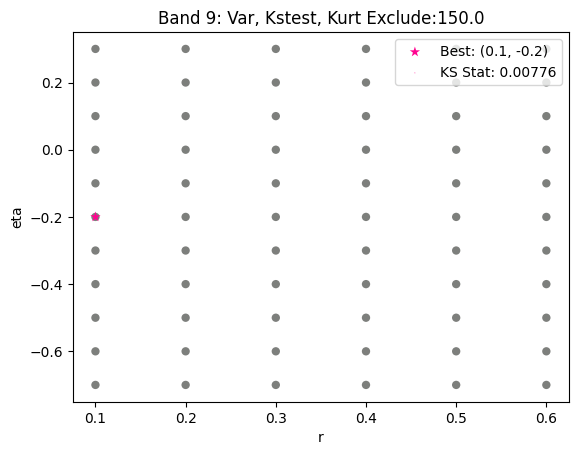

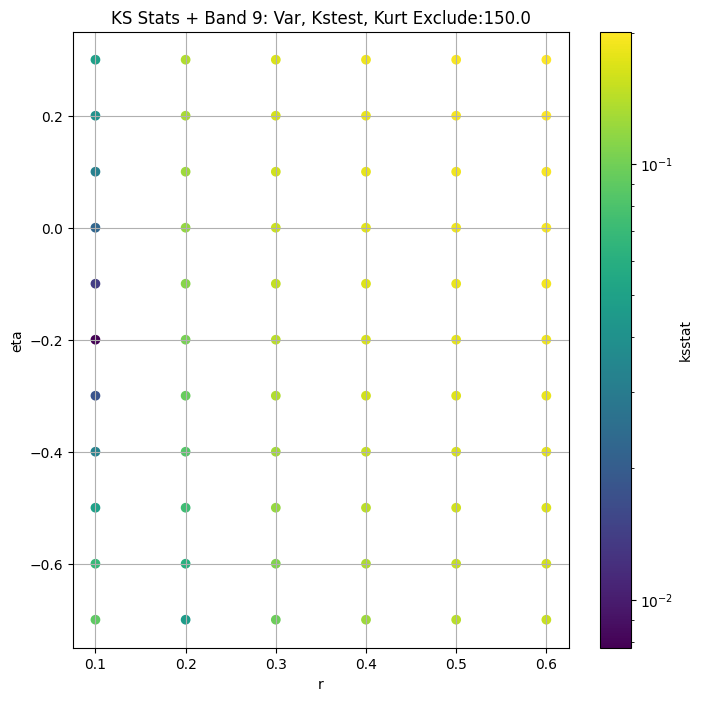

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,75.385260,60.889893,97.033820,81.302400,27.247470,234.38525,7281120.0,0.002611,0.2,-0.6,5.883362e-03,50.0,60.338478,0.000503
3,29.017336,24.287535,36.556973,61.603676,21.173878,214.87718,7281120.0,0.002593,0.3,-0.9,6.078074e-01,50.0,24.390676,0.000503
4,17.254368,13.904614,23.667818,109.402435,27.565727,413.15738,7281120.0,0.003464,0.3,-1.0,4.757063e-01,100.0,12.646924,0.000503
5,14.269713,10.821849,23.366629,269.051480,40.843310,922.23236,29124480.0,0.005287,0.1,-0.3,7.945664e-12,75.0,10.169940,0.000252
6,4.402337,3.275878,7.698638,353.294860,42.218037,1140.06900,14562240.0,0.006118,0.1,-0.2,1.229933e-12,100.0,2.886097,0.000356
7,1.025797,0.778365,1.671800,261.067350,39.629406,905.90160,14562240.0,0.006482,0.1,0.1,4.903001e-14,200.0,0.581578,0.000356
8,0.383323,0.286673,0.647704,305.185270,44.338146,1020.47360,14562240.0,0.006461,0.1,0.3,5.829513e-15,300.0,0.178462,0.000356
9,0.250326,0.179886,0.378133,216.880750,69.899605,652.36780,14789775.0,0.007760,0.1,-0.2,5.429837e-14,150.0,0.127414,0.000353


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 100 = 150, ksstat: 0.0037123546255522465, var: 51.0265998840332


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 75 = 125, ksstat: 0.003230773260015616, var: 52.77616500854492


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 50 = 100, ksstat: 0.003036512667537794, var: 54.81077194213867


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 25 = 75, ksstat: 0.0024931145702595803, var: 57.24894714355469


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 0 = 50, ksstat: 0.0022301062037185584, var: 60.338478088378906


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + -25 = 25, ksstat: 0.0017204118368136512, var: 64.70734405517578


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + -50 = 0, ksstat: 0.0026493499846053647, var: 75.38526153564453
Number of samples: 100000, Without approximation : 7281120.0


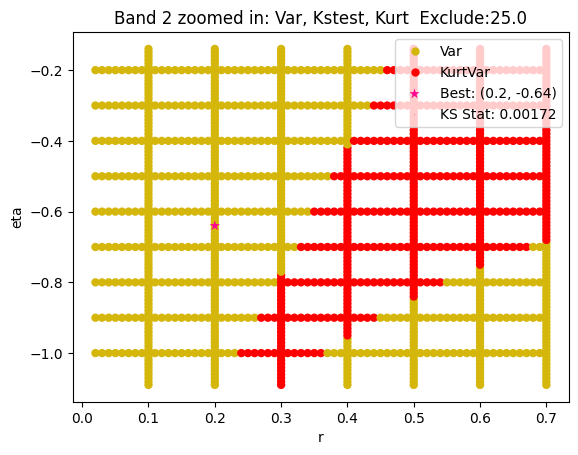

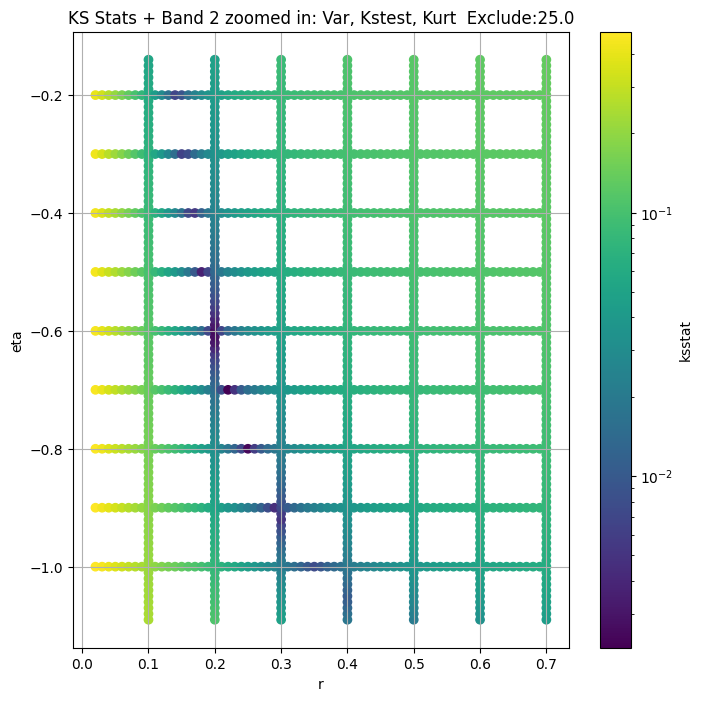

Band 3


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 50.0 + 100 = 150, ksstat: 0.0035214972900762045, var: 21.129114151000977


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 50.0 + 75 = 125, ksstat: 0.003311762475423974, var: 21.76627540588379


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 50.0 + 50 = 100, ksstat: 0.003156396826032141, var: 22.49227523803711


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 50.0 + 25 = 75, ksstat: 0.0025533280525786954, var: 23.343814849853516


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 50.0 + 0 = 50, ksstat: 0.0017962188069451136, var: 24.390676498413086


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 50.0 + -25 = 25, ksstat: 0.002059783196161069, var: 25.789113998413086


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 50.0 + -50 = 0, ksstat: 0.002134549337526992, var: 29.017335891723633
Number of samples: 100000, Without approximation : 7281120.0


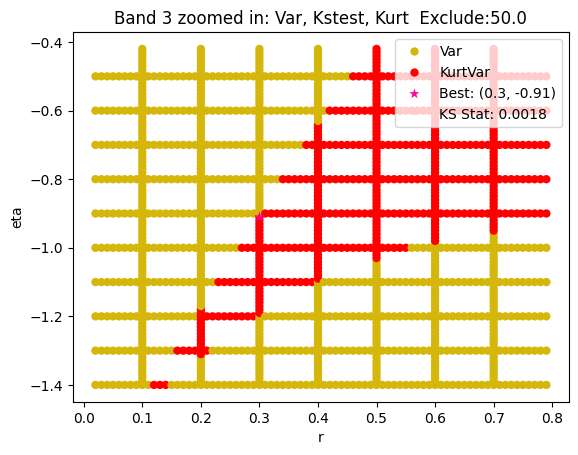

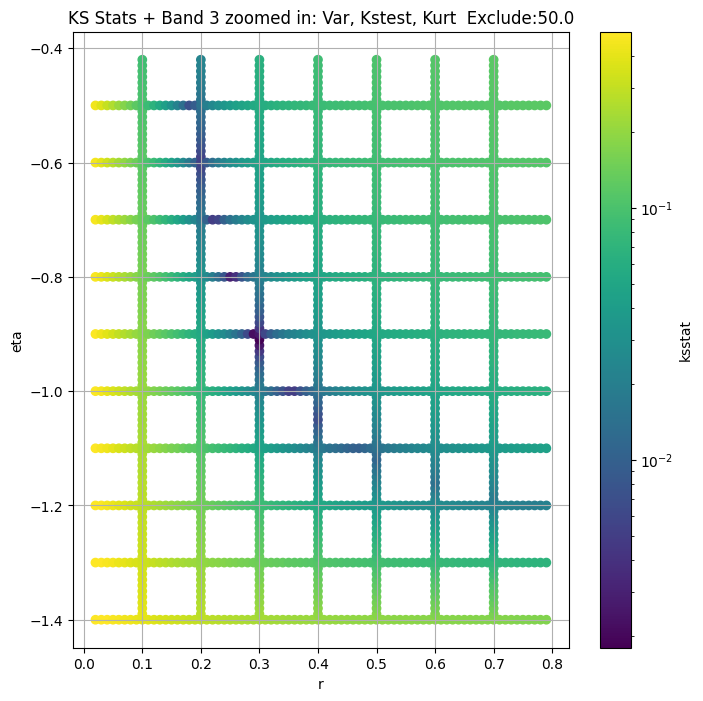

Band 4


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 100 = 200, ksstat: 0.005171922164156916, var: 11.020642280578613


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 75 = 175, ksstat: 0.00488989487706136, var: 11.360036849975586


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 50 = 150, ksstat: 0.0041039693833530184, var: 11.737137794494629


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 25 = 125, ksstat: 0.003679451314683946, var: 12.160880088806152


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 0 = 100, ksstat: 0.003464269738249204, var: 12.646924018859863


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + -25 = 75, ksstat: 0.004031562341437034, var: 13.218337059020996


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + -50 = 50, ksstat: 0.0030793537086740708, var: 13.919743537902832


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + -75 = 25, ksstat: 0.0023239188544318945, var: 14.865457534790039


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + -100 = 0, ksstat: 0.0018075103495084899, var: 17.25436782836914
Number of samples: 100000, Without approximation : 7281120.0


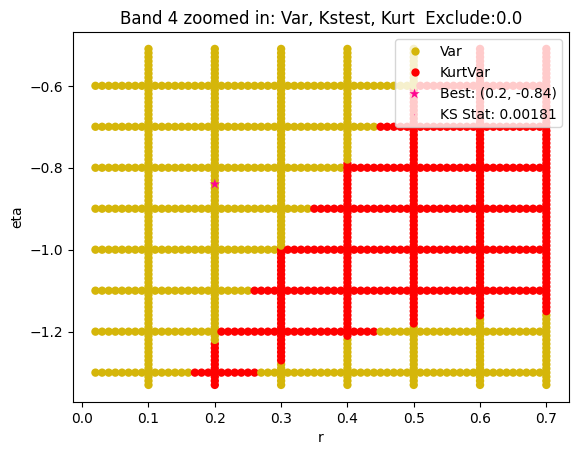

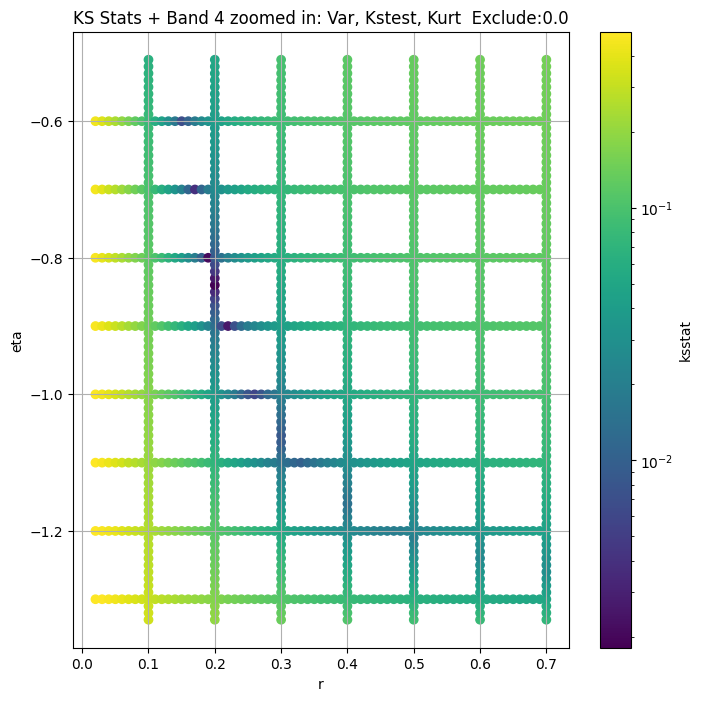

Band 5


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.0061773057077195714, var: 8.354107856750488


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.006344434457879836, var: 8.725152015686035


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.005866404773188994, var: 9.141066551208496


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.005265150992328972, var: 9.615510940551758


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.0051545962036474435, var: 10.169939994812012


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.004673044340118636, var: 10.843790054321289


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.004422054198013423, var: 11.736311912536621


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.006446009852771661, var: 14.269713401794434
Number of samples: 100000, Without approximation : 29124480.0


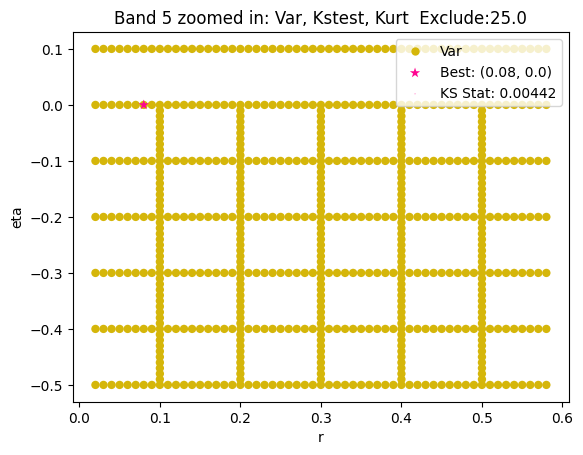

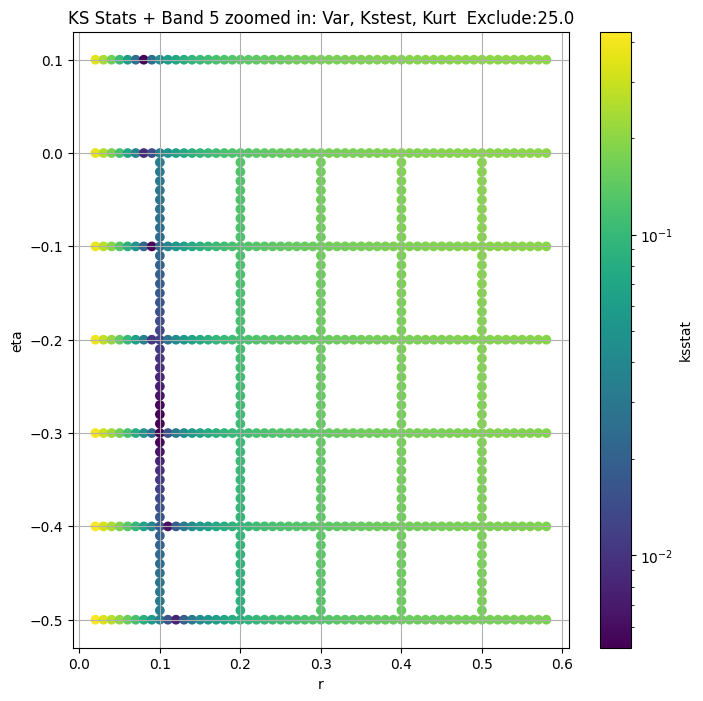

Band 6


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 100 = 200, ksstat: 0.0068103265374751705, var: 2.4009716510772705


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 75 = 175, ksstat: 0.006254176317790405, var: 2.502220392227173


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 50 = 150, ksstat: 0.00605506816220076, var: 2.614708185195923


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 25 = 125, ksstat: 0.0057442913388105424, var: 2.7412009239196777


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 0 = 100, ksstat: 0.005404183411669594, var: 2.8860974311828613


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + -25 = 75, ksstat: 0.006281092071333705, var: 3.056426525115967


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + -50 = 50, ksstat: 0.0057095328883456364, var: 3.2655699253082275


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + -75 = 25, ksstat: 0.008614626278686477, var: 3.5456557273864746


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + -100 = 0, ksstat: 0.00964630408563294, var: 4.402337074279785
Number of samples: 100000, Without approximation : 14562240.0


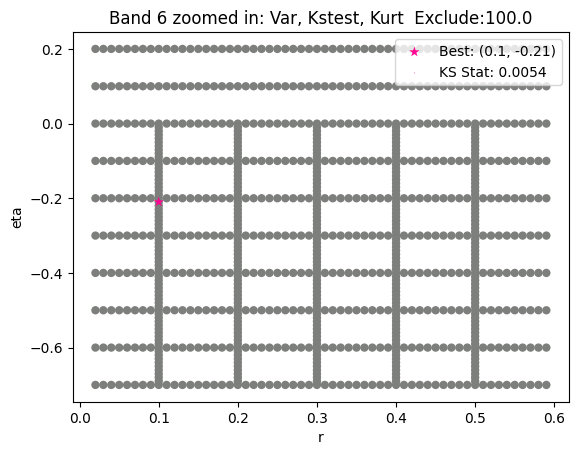

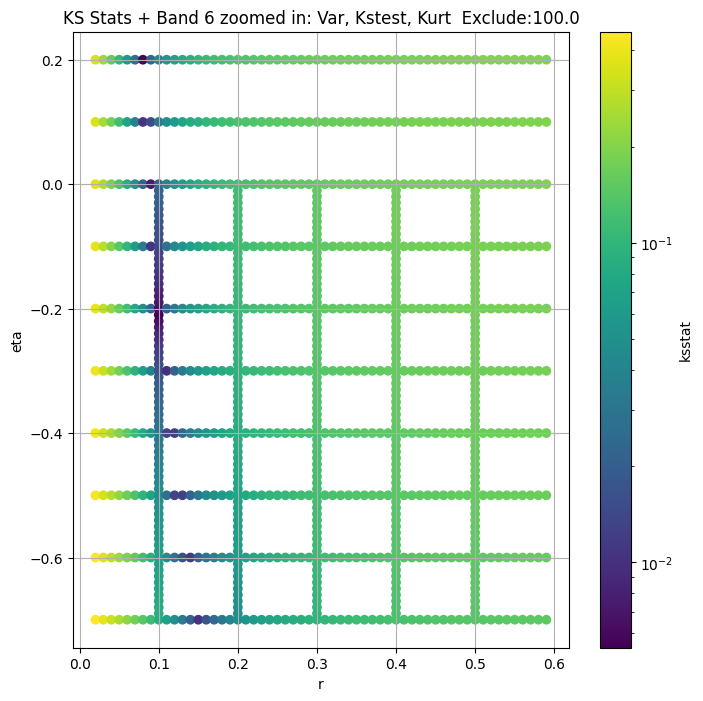

Band 7


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 100 = 300, ksstat: 0.0072696335011925555, var: 0.5050212740898132


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 75 = 275, ksstat: 0.00698118146654758, var: 0.5220010876655579


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 50 = 250, ksstat: 0.006576762282004569, var: 0.5402777791023254


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 25 = 225, ksstat: 0.006333808098916685, var: 0.5600523352622986


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 0 = 200, ksstat: 0.00614112245417644, var: 0.5815781354904175


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + -25 = 175, ksstat: 0.006148153796316268, var: 0.6051911115646362


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + -50 = 150, ksstat: 0.005665433106330978, var: 0.6313430666923523


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + -75 = 125, ksstat: 0.005434402061239048, var: 0.6606271862983704


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + -100 = 100, ksstat: 0.006792706304982077, var: 0.6940745711326599
Number of samples: 100000, Without approximation : 14562240.0


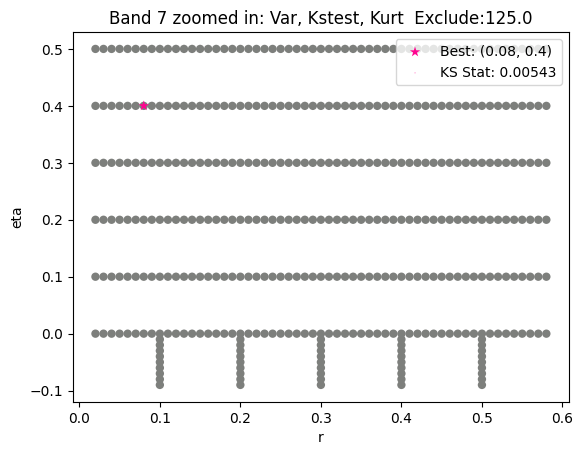

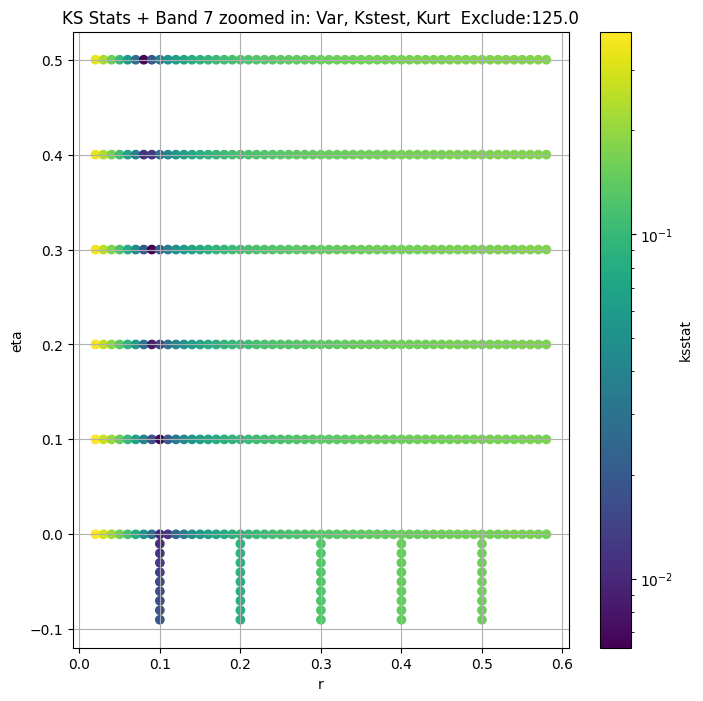

Band 8


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 100 = 400, ksstat: 0.007499148975894657, var: 0.1563563197851181


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 75 = 375, ksstat: 0.007151934191117905, var: 0.1613401621580124


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 50 = 350, ksstat: 0.006933085002831834, var: 0.16666029393672943


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 25 = 325, ksstat: 0.006595364155044067, var: 0.17235389351844788


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 0 = 300, ksstat: 0.006395333716738047, var: 0.17846231162548065


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + -25 = 275, ksstat: 0.006221247047647824, var: 0.18504559993743896


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + -50 = 250, ksstat: 0.006046377336396798, var: 0.19216930866241455


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + -75 = 225, ksstat: 0.005877021831611318, var: 0.19991359114646912


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + -100 = 200, ksstat: 0.007414508720402058, var: 0.2083909660577774
Number of samples: 100000, Without approximation : 14562240.0


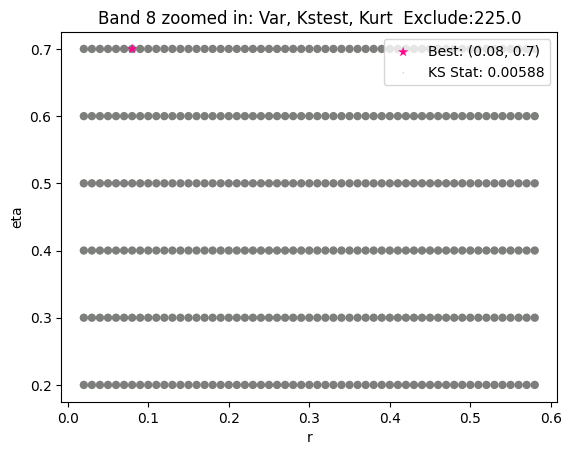

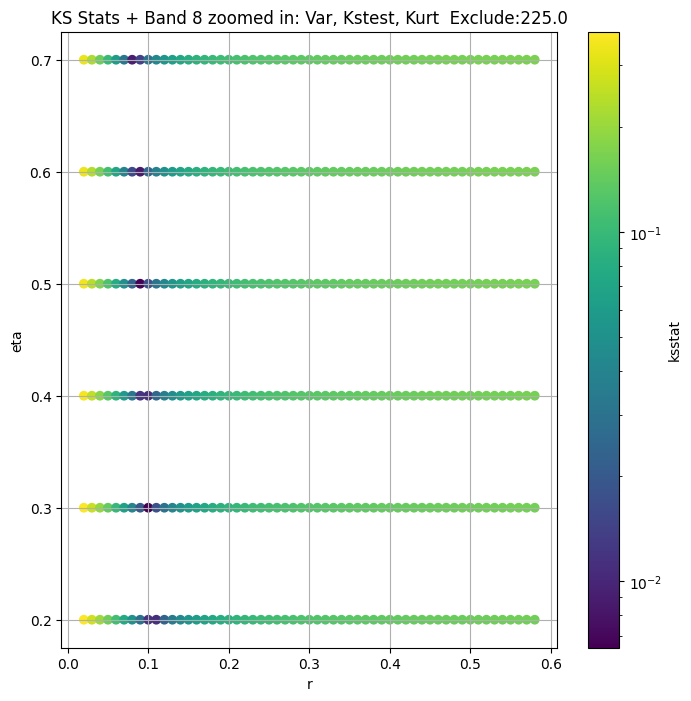

Band 9


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + 100 = 250, ksstat: 0.007759999999760292, var: 0.10110750049352646


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + 75 = 225, ksstat: 0.007759999999734091, var: 0.10661201924085617


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + 50 = 200, ksstat: 0.0077599999997221, var: 0.11273710429668427


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + 25 = 175, ksstat: 0.007759999999751632, var: 0.11961919814348221


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + 0 = 150, ksstat: 0.007759999999737532, var: 0.1274137943983078


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + -25 = 125, ksstat: 0.007759999999746858, var: 0.1363864690065384


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + -50 = 100, ksstat: 0.007759999999974121, var: 0.14691832661628723


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + -75 = 75, ksstat: 0.01010434183334763, var: 0.15961231291294098


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 9, 150.0 + -100 = 50, ksstat: 0.010166563725625744, var: 0.1756506860256195
Number of samples: 100000, Without approximation : 14789775.0


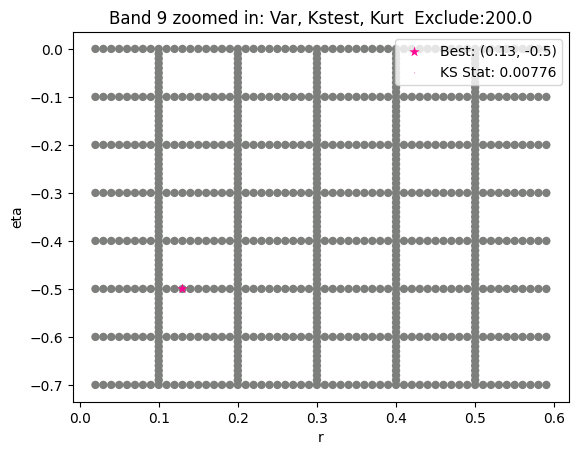

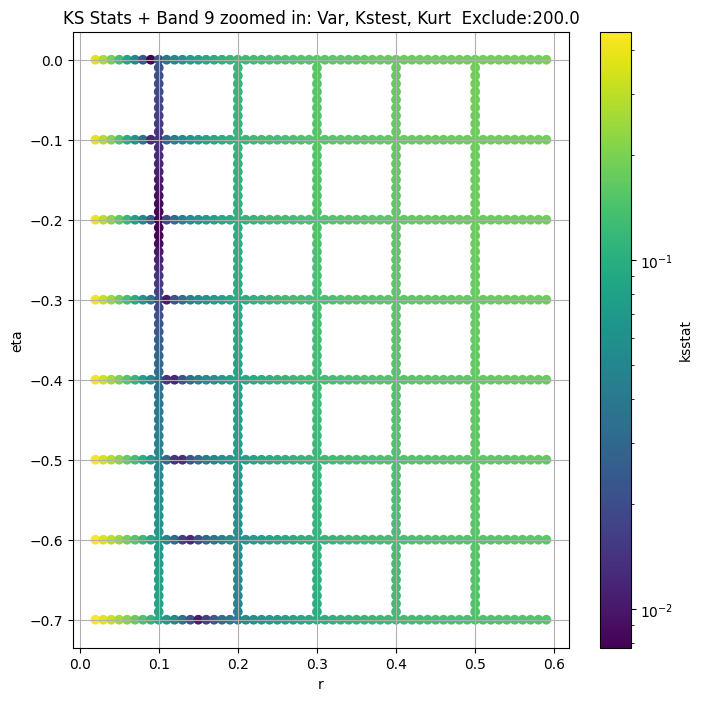

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,75.385260,60.889893,97.033820,81.302400,27.247470,234.38525,7281120.0,0.002611,0.2,-0.6,5.883362e-03,50.0,64.707344,0.000503,0.001720,0.20,-0.64,7.438198e-03,25.0,647938
3,29.017336,24.287535,36.556973,61.603676,21.173878,214.87718,7281120.0,0.002593,0.3,-0.9,6.078074e-01,50.0,24.390676,0.000503,0.001796,0.30,-0.91,6.318097e-01,50.0,575946
4,17.254368,13.904614,23.667818,109.402435,27.565727,413.15738,7281120.0,0.003464,0.3,-1.0,4.757063e-01,100.0,17.254368,0.000503,0.001808,0.20,-0.84,4.988585e-03,0.0,575946
5,14.269713,10.821849,23.366629,269.051480,40.843310,922.23236,29124480.0,0.005287,0.1,-0.3,7.945664e-12,75.0,11.736312,0.000252,0.004422,0.08,0.00,5.815936e-17,25.0,95989
6,4.402337,3.275878,7.698638,353.294860,42.218037,1140.06900,14562240.0,0.006118,0.1,-0.2,1.229933e-12,100.0,2.886097,0.000356,0.005404,0.10,-0.21,1.304602e-12,100.0,63993
7,1.025797,0.778365,1.671800,261.067350,39.629406,905.90160,14562240.0,0.006482,0.1,0.1,4.903001e-14,200.0,0.660627,0.000356,0.005434,0.08,0.40,3.076667e-19,125.0,63993
8,0.383323,0.286673,0.647704,305.185270,44.338146,1020.47360,14562240.0,0.006461,0.1,0.3,5.829513e-15,300.0,0.199914,0.000356,0.005877,0.08,0.70,2.044314e-20,225.0,53991
9,0.250326,0.179886,0.378133,216.880750,69.899605,652.36780,14789775.0,0.007760,0.1,-0.2,5.429837e-14,150.0,0.112737,0.000353,0.007760,0.13,-0.50,1.254896e-09,200.0,30844


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

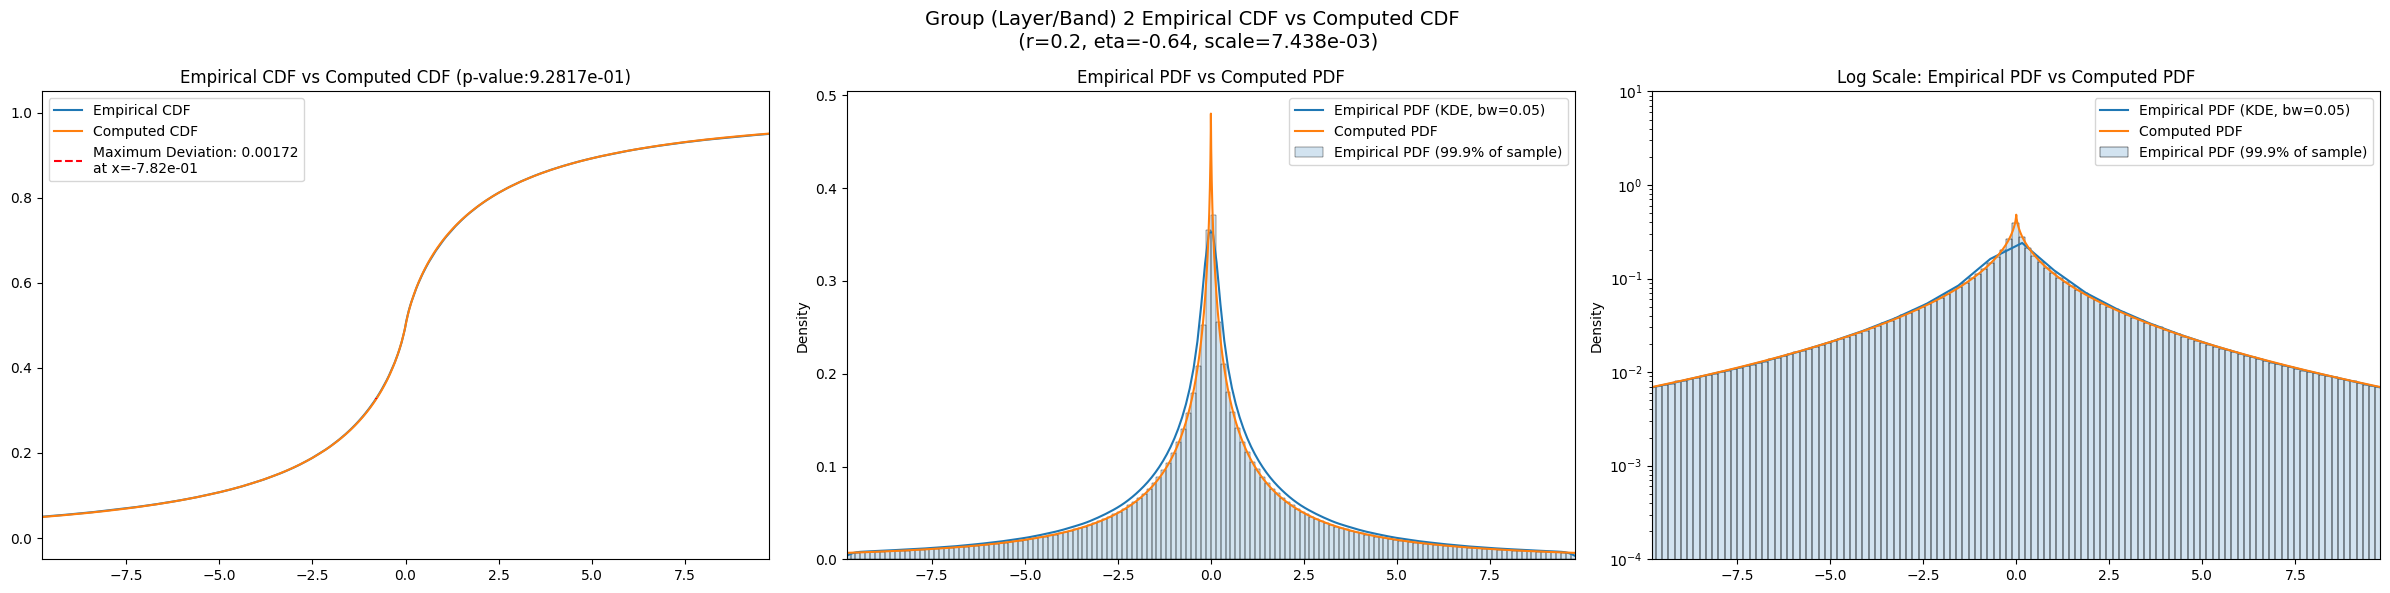

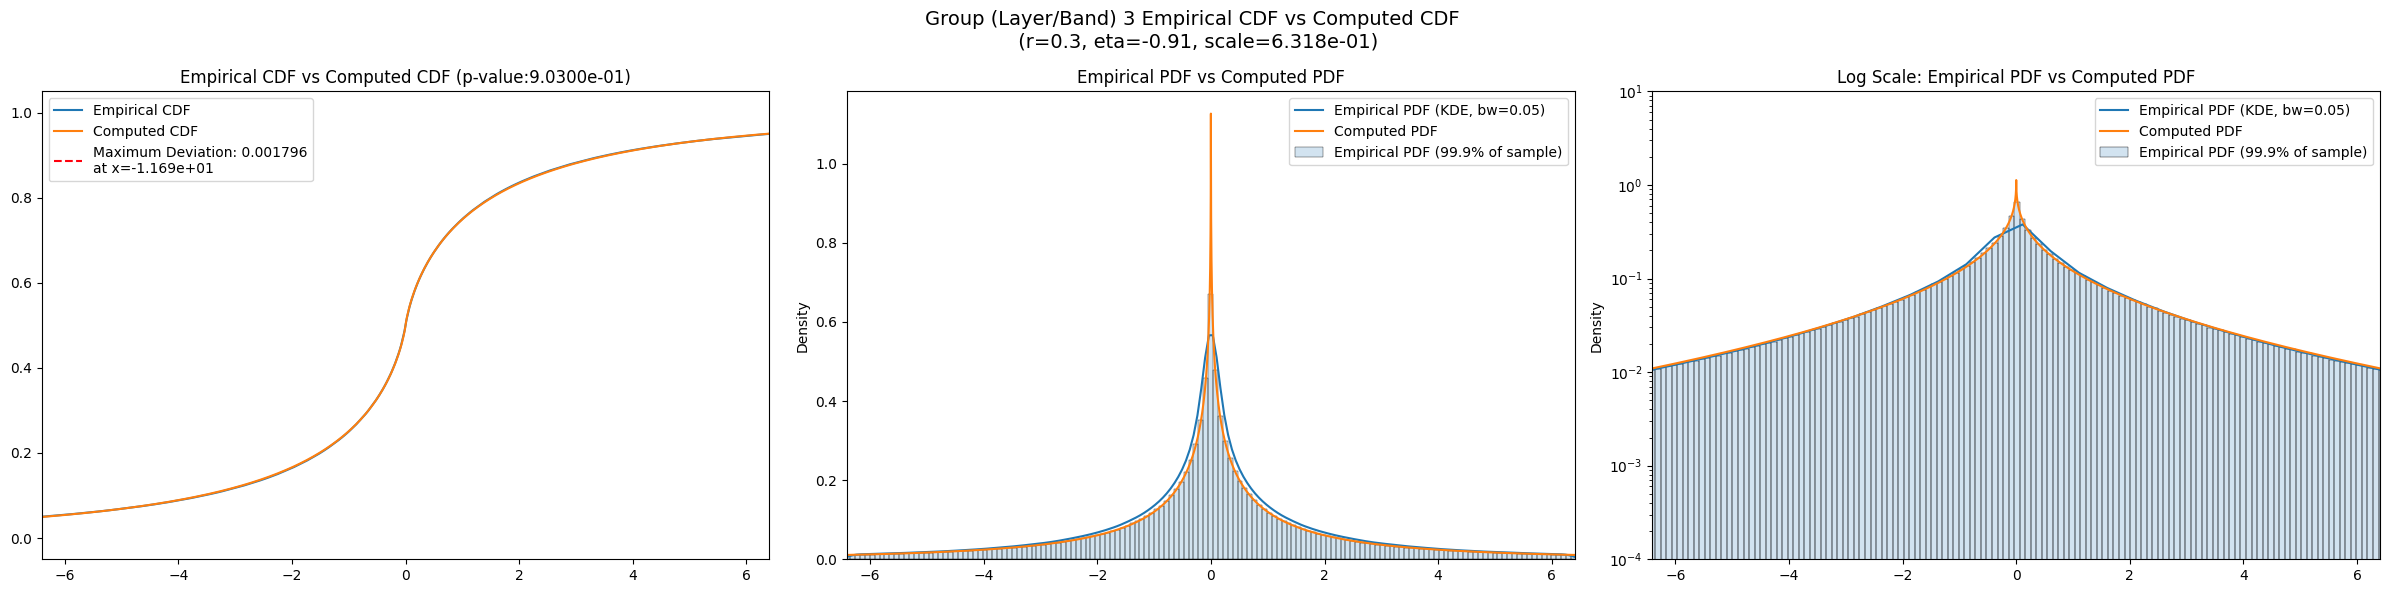

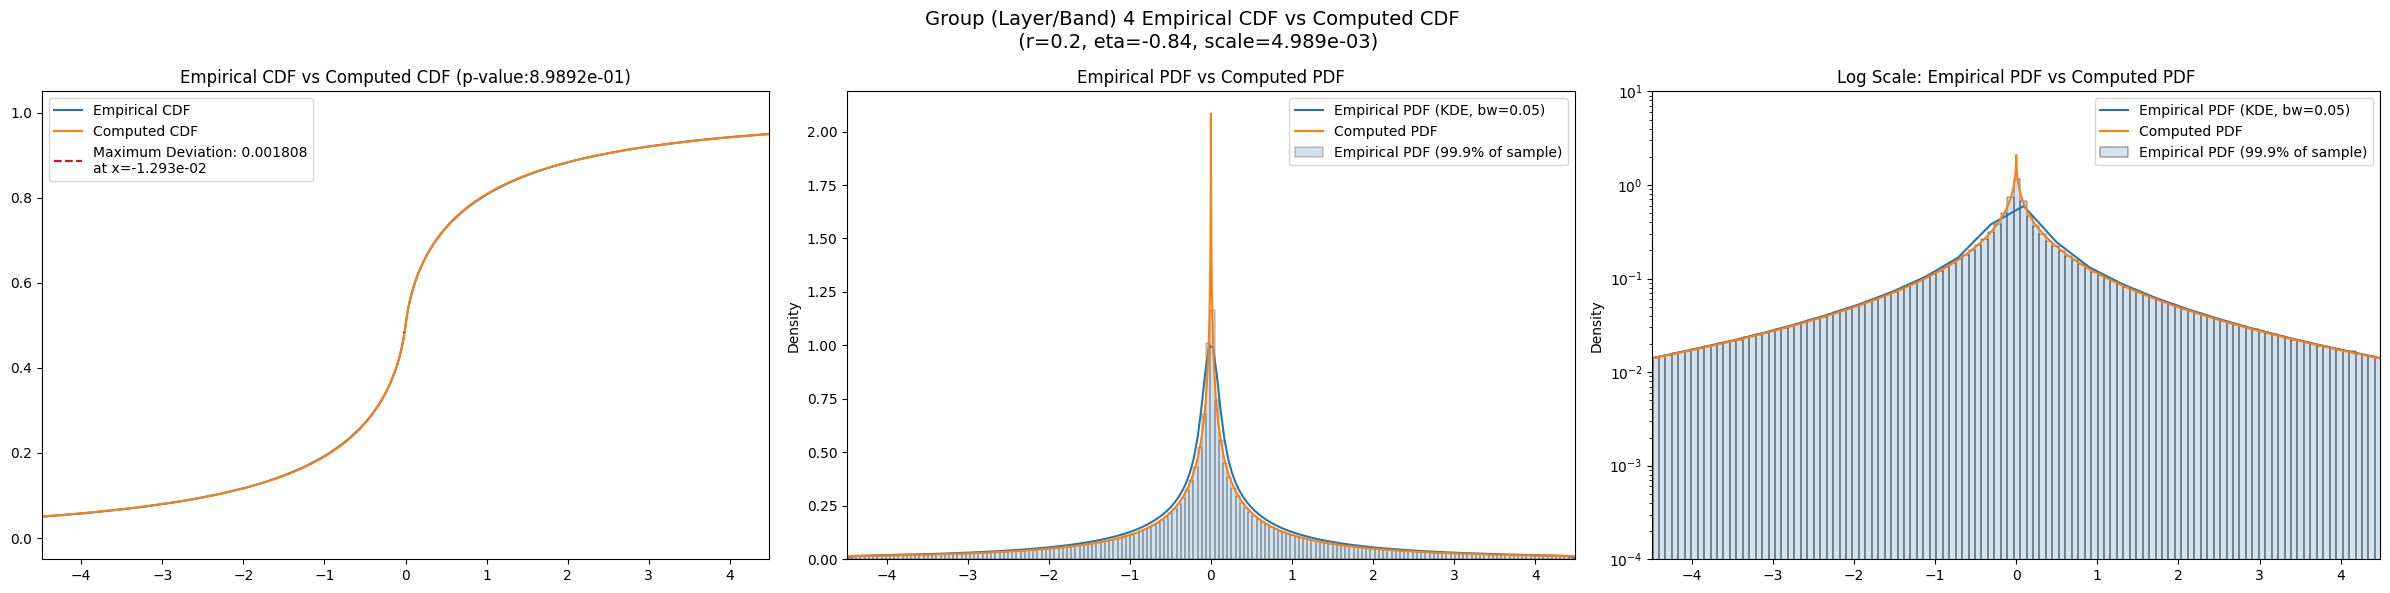

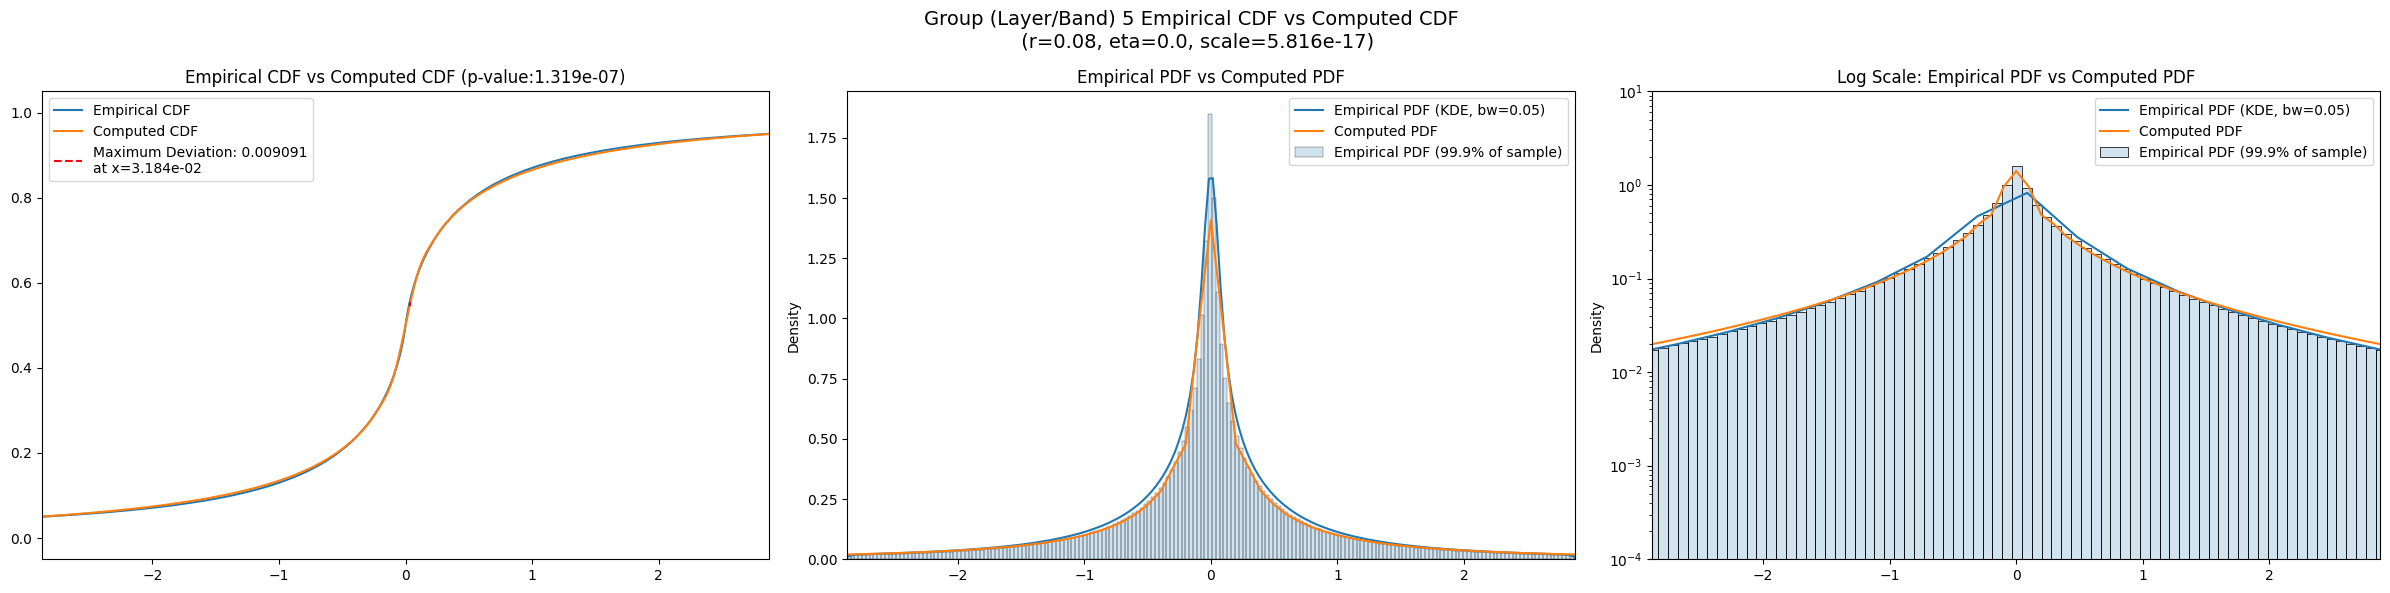

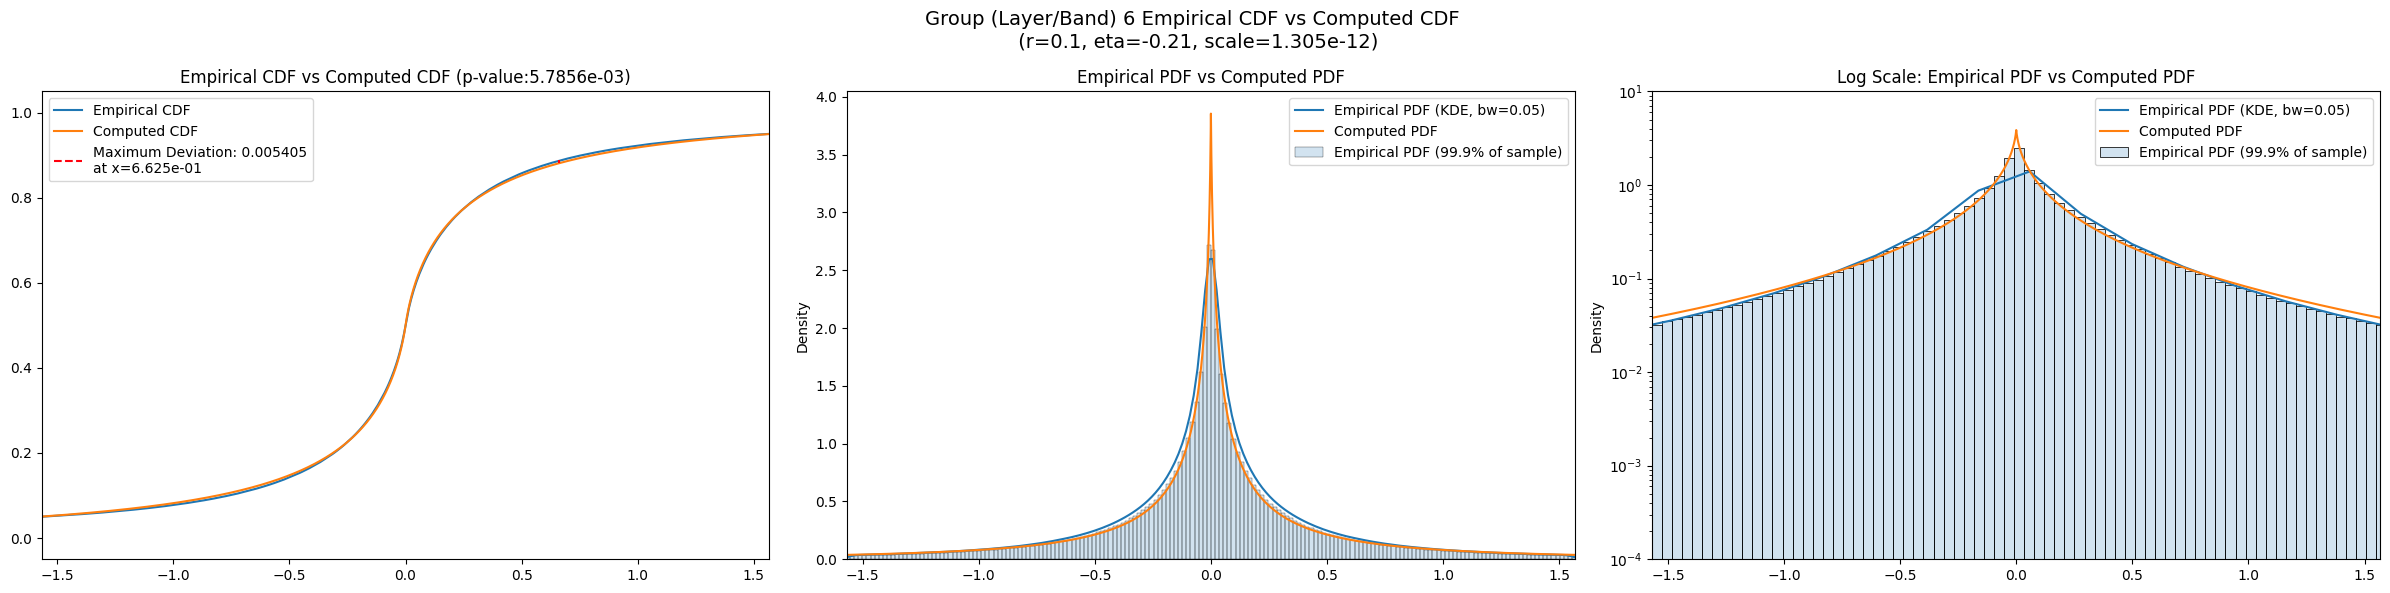

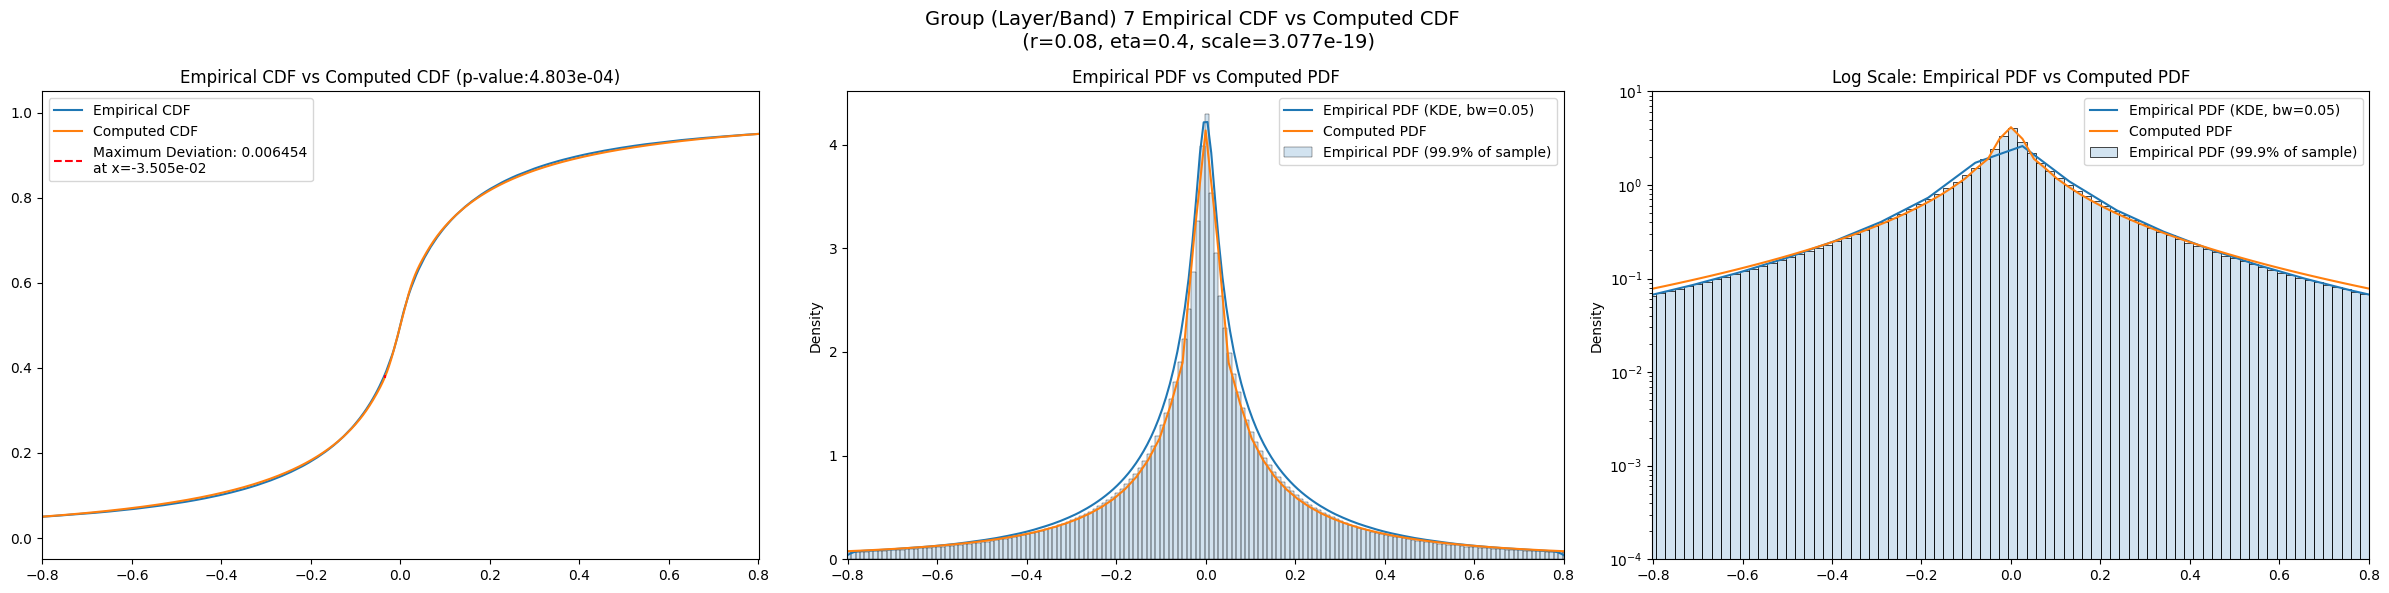

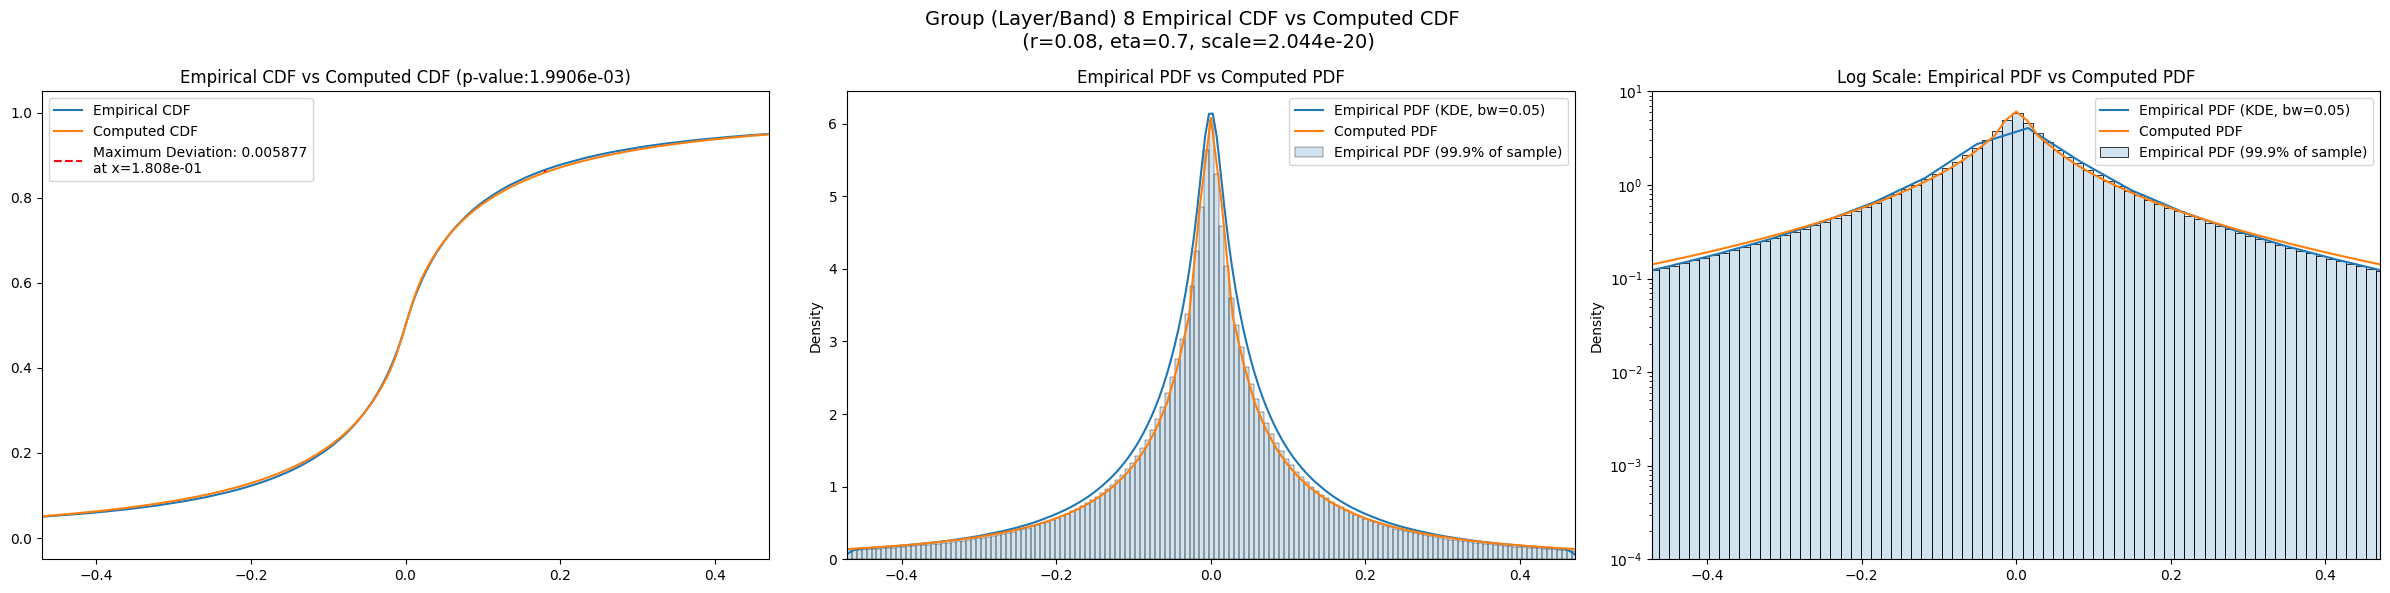

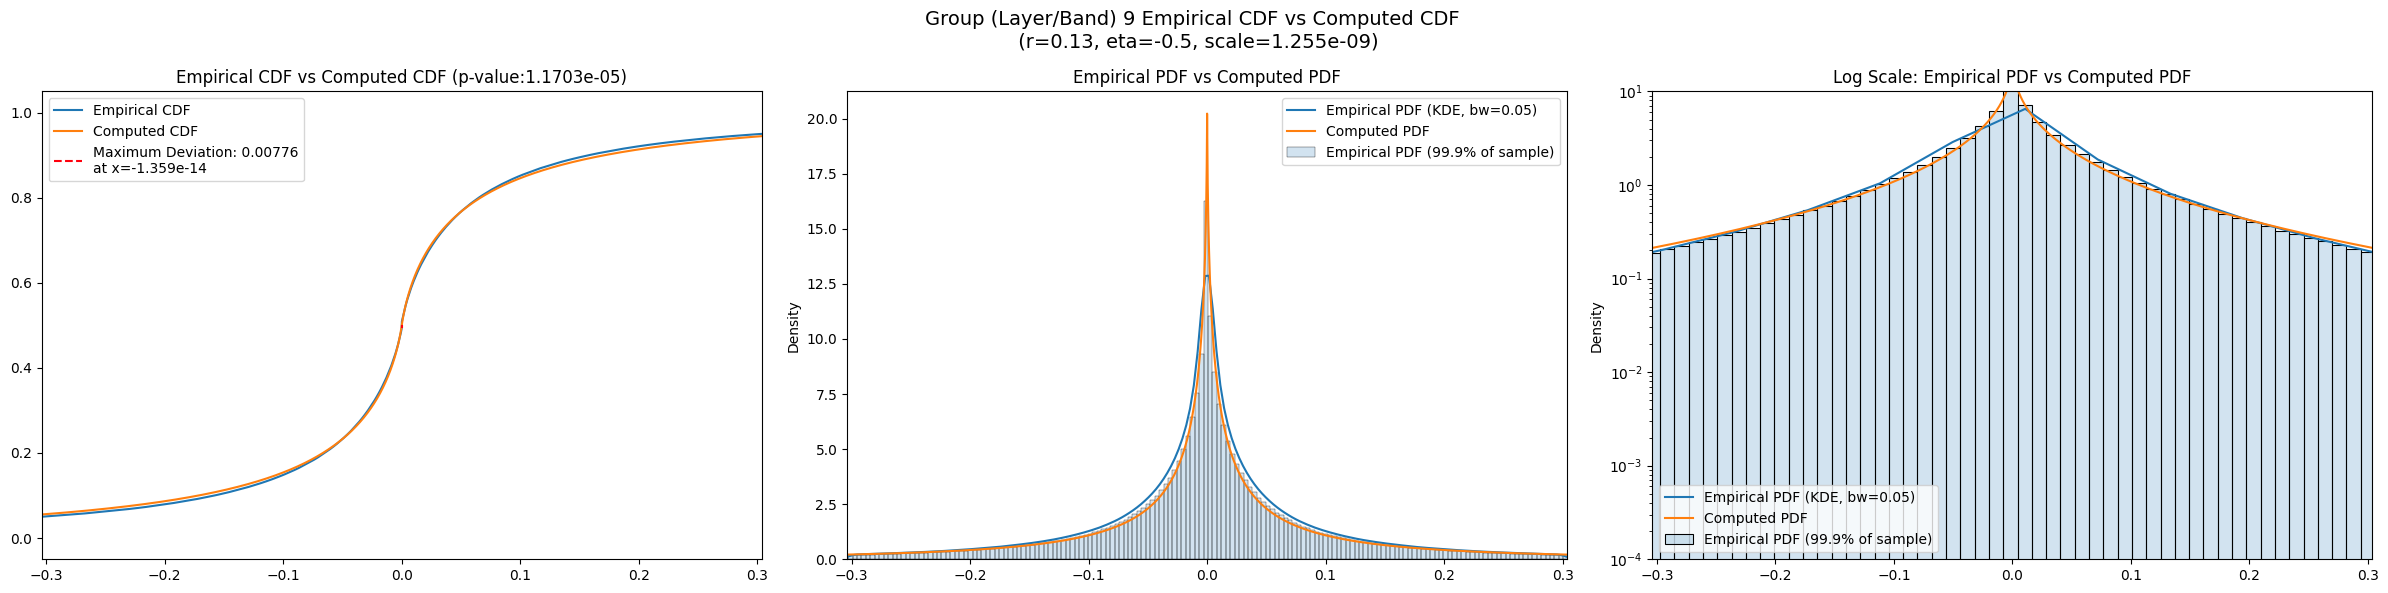

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,75.385260,60.889893,97.033820,81.302400,27.247470,234.38525,7281120.0,0.002611,0.2,-0.6,...,2.988800,0.067868,0.0,2.611110,0.041966,0.0,2.023270,0.042044,0.0,3.817337e-19
3,29.017336,24.287535,36.556973,61.603676,21.173878,214.87718,7281120.0,0.002593,0.3,-0.9,...,1.930440,0.069620,0.0,1.675350,0.043983,0.0,1.300110,0.044700,0.0,7.866367e-21
4,17.254368,13.904614,23.667818,109.402435,27.565727,413.15738,7281120.0,0.003464,0.3,-1.0,...,1.190750,0.077986,0.0,1.028190,0.053013,0.0,0.792799,0.053517,0.0,4.349353e-21
5,14.269713,10.821849,23.366629,269.051480,40.843310,922.23236,29124480.0,0.005287,0.1,-0.3,...,0.703550,0.076536,0.0,0.618246,0.051915,0.0,0.470068,0.050464,0.0,0.000000e+00
6,4.402337,3.275878,7.698638,353.294860,42.218037,1140.06900,14562240.0,0.006118,0.1,-0.2,...,0.408259,0.072376,0.0,0.360519,0.047652,0.0,0.274332,0.045835,0.0,0.000000e+00
7,1.025797,0.778365,1.671800,261.067350,39.629406,905.90160,14562240.0,0.006482,0.1,0.1,...,0.229298,0.067548,0.0,0.203486,0.042350,0.0,0.155948,0.040119,0.0,0.000000e+00
8,0.383323,0.286673,0.647704,305.185270,44.338146,1020.47360,14562240.0,0.006461,0.1,0.3,...,0.145763,0.063256,0.0,0.129691,0.037790,0.0,0.099988,0.035201,0.0,0.000000e+00
9,0.250326,0.179886,0.378133,216.880750,69.899605,652.36780,14789775.0,0.007760,0.1,-0.2,...,0.085674,0.070716,0.0,0.075028,0.045384,0.0,0.057603,0.044864,0.0,0.000000e+00


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.002611,0.000503,0.001720,0.067868,0.041966,0.042044
3,0.002593,0.000503,0.001796,0.069620,0.043983,0.044700
4,0.003464,0.000503,0.001808,0.077986,0.053013,0.053517
5,0.005287,0.000252,0.004422,0.076536,0.051915,0.050464
6,0.006118,0.000356,0.005404,0.072376,0.047652,0.045835
7,0.006482,0.000356,0.005434,0.067548,0.042350,0.040119
8,0.006461,0.000356,0.005877,0.063256,0.037790,0.035201
9,0.007760,0.000353,0.007760,0.070716,0.045384,0.044864


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,64.707344,0.001720,0.20,-0.64,7.438198e-03,25.0
3,24.390676,0.001796,0.30,-0.91,6.318097e-01,50.0
4,17.254368,0.001808,0.20,-0.84,4.988585e-03,0.0
5,11.736312,0.004422,0.08,0.00,5.815936e-17,25.0
6,2.886097,0.005404,0.10,-0.21,1.304602e-12,100.0
7,0.660627,0.005434,0.08,0.40,3.076667e-19,125.0
8,0.199914,0.005877,0.08,0.70,2.044314e-20,225.0
9,0.112737,0.007760,0.13,-0.50,1.254896e-09,200.0
